In [1]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "True"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam, SGD
from matplotlib import animation
from matplotlib import gridspec
from IPython.display import HTML

import gpflow
from gpflow.kernels import SquaredExponential, Periodic
from gpflow.models import GPR, SVGP, SGPR
from gpflow.optimizers import Scipy
from gpflow.utilities import multiple_assign, read_values
from tools.datasets import load_data
from tools.plotting import plot_1d_model

In [3]:
d = load_data("periodic1d")
X, Y = d.X, d.Y
sort = np.argsort(X.flatten())
X = X[sort, :]
Y = Y[sort, :]
pX = np.linspace(-5, 5, 3000)[:, None]

In [4]:
from gpflow.covariances import Kuu

In [5]:
def select_inducing(mm, tolerance=5.0):
    # This code is at the point where I was trying to get it to add / remove IPs as necessary,
    # rather than reselect them at every iteration. This would allow the addition/removal to
    # work, while also allowing gradient-based optimisation of the inducing inputs. I left off
    # trying to work out the rank-1 downdates, and a computationally efficient way of
    # computing them all... The key equation is that the cov with a point removed is
    #    K_(Z-Z-) = Q_11 - Q_12 Q_22^(-1) Q_21
    # where Q is K_ZZ.

    trainable = len(mm.inducing_variable.trainable_variables) > 0
    # mm.inducing_variable = gpflow.inducing_variables.InducingPoints(X[0, :, None])
    added = False
    while mm.upper_bound() - mm.elbo() > tolerance:
        added = True
        # print(mm.inducing_variable.Z.numpy().shape, mm.upper_bound() - mm.elbo())
        Z = mm.inducing_variable.Z.numpy()
        pfv = gpflow.conditionals.conditionals._sparse_conditional(X, mm.inducing_variable, mm.kernel, np.zeros_like(Z))[1].numpy()
        mm.inducing_variable = gpflow.inducing_variables.InducingPoints(np.vstack((Z, X[pfv.argmax(), :])))
    # print(mm.upper_bound() - mm.elbo())

    # Z = mm.inducing_variable.Z.numpy()
    while (mm.upper_bound() - mm.elbo() < tolerance):
        print(len(mm.inducing_variable.Z.numpy()))
        print("gap", mm.upper_bound() - mm.elbo())
        Z = mm.inducing_variable.Z.numpy()
        KzzI = np.linalg.inv(Kuu(mm.inducing_variable, mm.kernel, jitter=1e-6).numpy())
        mm.inducing_variable = gpflow.inducing_variables.InducingPoints(np.delete(Z.copy(), np.argmax(np.diag(KzzI)), axis=0))
    mm.inducing_variable = gpflow.inducing_variables.InducingPoints(Z)
    
    assert (mm.upper_bound() - mm.elbo()).numpy() < tolerance
    
    if not trainable:
        gpflow.set_trainable(mm.inducing_variable, False)

In [6]:
def select_inducing(mm, tolerance=5.0):
    # This version of the function recalculates the IPs every iteration from scratch

    trainable = len(mm.inducing_variable.trainable_variables) > 0
    mm.inducing_variable = gpflow.inducing_variables.InducingPoints(X[0, :, None])
    while mm.upper_bound() - mm.elbo() > tolerance:
        Z = mm.inducing_variable.Z.numpy()
        pfv = gpflow.conditionals.conditionals._sparse_conditional(X, mm.inducing_variable, mm.kernel, np.zeros_like(Z))[1].numpy()
        mm.inducing_variable = gpflow.inducing_variables.InducingPoints(np.vstack((Z, X[pfv.argmax(), :])))

    assert (mm.upper_bound() - mm.elbo()).numpy() < tolerance
    
    if not trainable:
        gpflow.set_trainable(mm.inducing_variable, False)

In [7]:
class GPR_mse(GPR):
    def maximum_log_likelihood_objective(self) -> tf.Tensor:
        return -tf.reduce_mean((self.predict_y(self.data[0])[0] - self.data[1]) ** 2.0)
    
class GPR_lpd(GPR):
    def maximum_log_likelihood_objective(self) -> tf.Tensor:
        return tf.reduce_sum(self.predict_log_density(self.data))

def animate_training(mm, plot_var=None, iterations=None, iterations_per_frame=None, learning_rate=None, unfreeze=None, select_tol=5.0,
                     opt="Adam"):
    learning_rate = 0.01 if learning_rate is None else learning_rate
    if isinstance(mm, GPR_mse):
        iterations, iterations_per_frame = 10000, 150
    elif isinstance(mm, GPR_lpd):
        iterations, iterations_per_frame = 1600, 30
        plot_var = True
    else:
        if not iterations or not iterations_per_frame:
            raise NotImplemented()

    fig = plt.figure(constrained_layout=True, figsize=(8, 4.8))
    spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
    ax_m, ax_loss, ax_hyp = [fig.add_subplot(s) for s in [spec[0, :], spec[1, 0], spec[1, 1]]]
    ax_m.set_xlabel("regression input")
    ax_m.set_ylabel("regression target")

    ax_m.plot(X, Y, 'x')
    pY, pYv = mm.predict_y(pX)
    line_mean, = ax_m.plot(pX, pY.numpy())
    Z = mm.inducing_variable.Z.numpy()
    line_inducing, = ax_m.plot(Z, np.zeros_like(Z), '|', color='k')
    if plot_var:
        fill = ax_m.fill_between(pX.flatten(),
                          (pY - 2 * pYv ** 0.5).numpy().flatten(),
                          (pY + 2 * pYv ** 0.5).numpy().flatten(),
                        alpha=0.3, label="2$\sigma$ func" if plot_var == "f" else "2$\sigma$ data")
    ax_m.set_ylim([-2.5, 2.5])
    ax_m.set_title("Fit with 1 neuron")

    ax_loss.set_xlim(0, iterations)
    ax_loss.set_ylim(-100, 10)
    line_loss, = ax_loss.plot([], [])
    ax_loss.set_xlabel("iteration")
    ax_loss.set_ylabel("training objective")

    ax_hyp.set_xlim(0, iterations // iterations_per_frame)
    ax_hyp.set_ylim(0, 40)
    ax_hyp.set_xlabel("iteration")
    ax_hyp.set_ylabel("Num neurons")
    Ms = [1]
    line_num_inducing, = ax_hyp.plot(Ms)

    logstep = []
    logf = []
    loghyp = []
    # training_loss = mm.training_loss_closure(data=(X, Y), compile=False) if type(mm) is SVGP else mm.training_loss_closure(compile=True)
    if opt == "SGD":
        optimizer = SGD(learning_rate=learning_rate)
    elif opt == "Adam":
        optimizer = Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    # @tf.function
    # def optimization_step():
    #     optimizer.minimize(training_loss, mm.trainable_variables)

    def drawframe(step, fill):
        print(step, end=" ")
        
        if step > 0:
            start_iteration = (step - 1) * iterations_per_frame
            for i in range(iterations_per_frame):
                if (start_iteration + i) % 10 == 0:
                    select_inducing(mm, tolerance=select_tol)
                    M = len(mm.inducing_variable.Z.numpy())
                    Ms.append(M)
                    ax_m.set_title(f"Fit with {M} neurons")

                with tf.GradientTape() as tape:
                    optimizer.minimize(mm.training_loss, mm.trainable_variables)

        if unfreeze is not None:
            if step == unfreeze:
                gpflow.set_trainable(mm.kernel.kernels[1], True)

        elbo = -mm.training_loss().numpy()
        print(f"{elbo:.2f}")
        logf.append(elbo)
        logstep.append(step * iterations_per_frame)
        if type(mm.kernel) is SquaredExponential:
            loghyp.append((mm.kernel.lengthscales.numpy(), mm.likelihood.variance.numpy() ** 0.5))

        pY, pYv = mm.predict_y(pX)
        line_mean.set_data(pX, pY.numpy())
        Z = mm.inducing_variable.Z.numpy()
        line_inducing.set_data(Z, np.zeros_like(Z))
        if plot_var:
            for c in ax_m.collections:
                c.remove()

            drawframe.fill = ax_m.fill_between(pX.flatten(),
                              (pY - 2 * pYv ** 0.5).numpy().flatten(),
                              (pY + 2 * pYv ** 0.5).numpy().flatten(),
                              color='C0',
                              alpha=0.3, label="2$\sigma$ func" if plot_var == "f" else "2$\sigma$ data")
        
        line_loss.set_data(logstep, logf)
        line_num_inducing.set_data(np.arange(len(Ms)), Ms)
        
        return line_mean, line_loss

    anim = animation.FuncAnimation(fig, drawframe, fargs=(None,), frames=iterations // iterations_per_frame, interval=100, blit=False)
    print(f"frames: {iterations // iterations_per_frame}")
    return fig, anim

In [8]:
sqexp = SquaredExponential()
sqexp.lengthscales.assign(0.01)
periodic = Periodic(SquaredExponential())
periodic.base_kernel.variance.assign(25e-3)
# periodic.period = 1.2
m = SGPR((X, Y), sqexp + periodic, X[0, :, None])
# gpflow.set_trainable(m.inducing_variable, False)
m.likelihood.variance.assign(0.1)

fig, anim = animate_training(m, iterations=500, iterations_per_frame=10, learning_rate=0.01, plot_var=True, select_tol=5.0, opt="SGD")
plt.close(fig)
HTML(anim.to_html5_video())

frames: 50
0 -322.45
0 -322.45
1 -47.36
2 -43.38
3 -41.00
4 -38.88
5 -37.33
6 -36.38
7 -35.55
8 -34.16
9 -35.34
10 -35.70
11 -35.56
12 -29.98
13 -33.15
14 -34.02
15 -33.86
16 -34.03
17 -32.51
18 -34.32
19 -36.23
20 -34.54
21 -29.87
22 -33.79
23 -33.13
24 -31.64
25 -31.75
26 -32.58
27 -29.88
28 -31.71
29 -33.61
30 -39.07
31 -32.66
32 -30.32
33 -30.66
34 -32.70
35 -35.24
36 -29.64
37 -37.14
38 -34.35
39 -31.10
40 -31.35
41 -31.17
42 -29.33
43 -31.32
44 -33.72
45 -28.53
46 -27.92
47 -28.99
48 -34.99
49 -29.85


In [9]:
len(m.inducing_variable)

/var/folders/v4/3sn20t35493cy7fpy4m85xm40000gn/T/ipykernel_6682/4075829689.py:1: DeprecationWarning: Call to deprecated method __len__. (len(iv) should return an `int`, but this actually returns a `tf.Tensor`. Use `iv.num_inducing` instead.)
  len(m.inducing_variable)


19

In [10]:
select_inducing(m)

In [11]:
m.inducing_variable = gpflow.inducing_variables.InducingPoints(np.sort(m.inducing_variable.Z.numpy().flatten())[:, None])

In [12]:
KzzI = np.linalg.inv(Kuu(m.inducing_variable, m.kernel, jitter=1e-6).numpy())

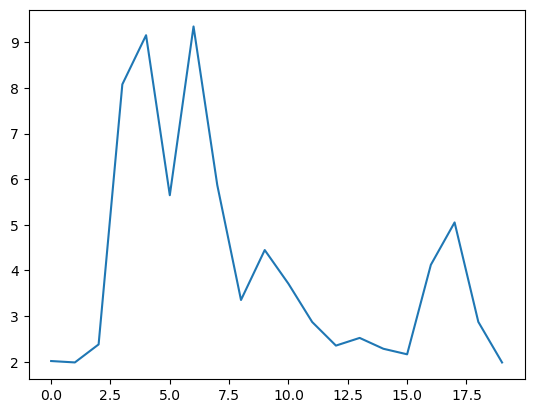

In [13]:
plt.plot(np.diag(KzzI))

In [14]:
np.argmax(np.diag(KzzI))

6

In [15]:
m

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.44493653396808164
SGPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.13988789695994758
SGPR.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.2628147712500847
SGPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.41705
SGPR.kernel.kernels[1].period,Parameter,Softplus,,True,(),float64,1.5004
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.15855299274402973
SGPR.inducing_variable.Z,Parameter,Identity,,True,"(20, 1)",float64,[[-2.89662...


In [16]:
sqexp = SquaredExponential()
sqexp.lengthscales.assign(0.65)
periodic = Periodic(SquaredExponential())
periodic.base_kernel.variance.assign(1.1e-3)
# periodic.period = 1.2
m = SGPR((X, Y), sqexp + periodic, X[0, :, None])
gpflow.set_trainable(m.inducing_variable, False)
m.likelihood.variance.assign(0.1)

fig, anim = animate_training(m, iterations=2000, iterations_per_frame=10, learning_rate=0.01, plot_var=True, select_tol=5.0)
plt.close(fig)
HTML(anim.to_html5_video())

frames: 200
0 -320.09
0 -320.09
1 -60.58
2 -56.56
3 -52.71
4 -49.22
5 -46.69
6 -44.39
7 -42.65
8 -41.61
9 -41.28
10 -39.65
11 -38.80
12 -36.81
13 -35.40
14 -33.89
15 -32.95
16 -32.90
17 -32.32
18 -32.19
19 -32.07
20 -31.98
21 -31.89
22 -31.81
23 -31.72
24 -31.60
25 -31.51
26 -31.40
27 -30.57
28 -31.18
29 -31.04
30 -30.15
31 -30.72
32 -29.76
33 -30.19
34 -29.17
35 -28.29
36 -27.89
37 -26.84
38 -25.76
39 -23.84
40 -21.47
41 -18.89
42 -17.05
43 -15.27
44 -13.74
45 -12.23
46 -11.44
47 -10.21
48 -9.42
49 -8.57
50 -7.59
51 -6.95
52 -6.07
53 -5.26
54 -4.49
55 -3.78
56 -3.07
57 -2.42
58 -1.79
59 -1.21
60 -0.66
61 -0.13
62 0.51
63 0.97
64 1.39
65 1.78
66 2.13
67 2.49
68 2.77
69 3.08
70 3.44
71 3.68
72 3.88
73 4.06
74 4.21
75 4.35
76 4.45
77 4.54
78 4.67
79 4.75
80 4.83
81 4.89
82 4.93
83 5.00
84 5.12
85 5.09
86 5.13
87 5.17
88 5.20
89 5.18
90 5.25
91 5.28
92 5.30
93 5.32
94 5.32
95 5.37
96 5.39
97 5.41
98 5.43
99 5.38
100 5.40
101 5.42
102 5.43
103 5.45
104 5.46
105 5.48
106 5.43
107 5.53
108 5

In [16]:
m

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.7817871220595014
SGPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.12611915838776133
SGPR.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,,True,(),float64,0.002532118249155175
SGPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0398
SGPR.kernel.kernels[1].period,Parameter,Softplus,,True,(),float64,0.9546238027639647
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.019627299892511007
SGPR.inducing_variable.Z,Parameter,Identity,,False,"(23, 1)",float64,[[-2.89662...


In [11]:
sqexp = SquaredExponential()
sqexp.lengthscales.assign(0.005)
periodic = Periodic(SquaredExponential())
periodic.base_kernel.variance.assign(1.1e-3)
# periodic.period = 1.2
m = SGPR((X, Y), sqexp + periodic, X[0, :, None])
gpflow.set_trainable(m.inducing_variable, False)
# We can't quite initialise at the poor solution we found earlier, due to local minima.
# But we can initialise quite nearby!
m.likelihood.variance.assign(0.1)

fig, anim = animate_training(m, iterations=2000, iterations_per_frame=10, learning_rate=0.01, plot_var=True)
plt.close(fig)
HTML(anim.to_html5_video())

frames: 200
0 -323.99
0 -323.99
1 29
gap tf.Tensor(4.512362375341972, shape=(), dtype=float64)
29
-43.29
2 29
gap tf.Tensor(3.6575538146845474, shape=(), dtype=float64)
29
-42.68
3 29
gap tf.Tensor(2.9940765287068984, shape=(), dtype=float64)
29
-42.13
4 29
gap tf.Tensor(2.5024436334121916, shape=(), dtype=float64)
29
-41.57
5 29
gap tf.Tensor(2.136525370963831, shape=(), dtype=float64)
29
-41.00
6 29
gap tf.Tensor(1.8508524797268606, shape=(), dtype=float64)
29
-40.41
7 29
gap tf.Tensor(1.6209036547918814, shape=(), dtype=float64)
29
-39.83
8 29
gap tf.Tensor(1.4340652986673703, shape=(), dtype=float64)
29
-39.24
9 29
gap tf.Tensor(1.2811968187551486, shape=(), dtype=float64)
29
-38.66
10 29
gap tf.Tensor(1.1551801056579052, shape=(), dtype=float64)
29
-38.09
11 29
gap tf.Tensor(1.05063134456951, shape=(), dtype=float64)
28
gap tf.Tensor(4.249781451224457, shape=(), dtype=float64)
28
-38.22
12 28
gap tf.Tensor(3.640924479648568, shape=(), dtype=float64)
28
-37.46
13 28
gap tf.Tensor(3

In [ ]:
sqexp = SquaredExponential()
sqexp.lengthscales.assign(0.7)
periodic = Periodic(SquaredExponential())
periodic.base_kernel.variance.assign(1.1e-3)
# periodic.period = 1.2
m = SGPR((X, Y), sqexp + periodic, X[0, :, None])
gpflow.set_trainable(m.inducing_variable, False)
# We can't quite initialise at the poor solution we found earlier, due to local minima.
# But we can initialise quite nearby!
m.likelihood.variance.assign(0.1)

fig, anim = animate_training(m, iterations=1500, iterations_per_frame=10, learning_rate=0.01, plot_var=True)
plt.close(fig)
HTML(anim.to_html5_video())

In [122]:
sqexp = SquaredExponential()
sqexp.lengthscales.assign(0.7)
periodic = Periodic(SquaredExponential())
periodic.base_kernel.variance.assign(1.1e-3)
# periodic.period = 1.2
m = SGPR((X, Y), sqexp + periodic, X[0, :, None])
gpflow.set_trainable(m.inducing_variable, False)
gpflow.set_trainable(m.kernel.kernels[1], False)
# We can't quite initialise at the poor solution we found earlier, due to local minima.
# But we can initialise quite nearby!
m.likelihood.variance.assign(0.1)

fig, anim = animate_training(m, iterations=3000, iterations_per_frame=10, learning_rate=0.01, plot_var=True, unfreeze=100)
plt.close(fig)
HTML(anim.to_html5_video())

frames: 300
0 -318.16073071786957
0 -318.16073071786957
1 -61.00638278484219
2 -57.206593216525
3 -53.80058911116858
4 -50.14521231271432
5 -47.30441580699134
6 -44.89250373795282
7 -43.2722956611746
8 -41.77716751824842
9 -40.00205655805771
10 -38.67265962583997
11 -37.261337158823466
12 -35.10415899382185
13 -33.30032639723464
14 -32.77659162146776
15 -32.646311169896535
16 -32.483690524380776
17 -32.36594737143666
18 -32.18497582864038
19 -32.120618960684794
20 -32.05578433487121
21 -31.69798174450367
22 -31.624604077580386
23 -31.556497550193107
24 -30.84308323622828
25 -30.82710663494009
26 -30.731690137807597
27 -30.637022546988895
28 -30.543894688992868
29 -30.45216478263793
30 -30.36144568223089
31 -30.271936856775657
32 -30.183790802243358
33 -30.09712594039034
34 -30.012073391049785
35 -29.92875041775415
36 -29.84726624543729
37 -29.767722940618725
38 -29.6902139983118
39 -29.614824608979923
40 -29.541631325803078
41 -29.47070185343256
42 -29.40209492060682
43 -29.33586017416

In [113]:
m

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.0002907360984483648
SGPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.3369522310065837
SGPR.kernel.kernels[1].base_kernel.variance,Parameter,Softplus,,True,(),float64,1.22395
SGPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.49781045018578773
SGPR.kernel.kernels[1].period,Parameter,Softplus,,True,(),float64,1.00052
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.011930619087042014
SGPR.inducing_variable.Z,Parameter,Identity,,False,"(12, 1)",float64,[[-2.89662...


In [99]:
for tol in range(1, 10):
    select_inducing(m, tolerance=tol)
    print(m.inducing_variable.Z.numpy().shape)
    print(m.elbo().numpy())

(18, 1)
5.5350501096292035
(17, 1)
5.512637610415005
(16, 1)
5.4620874773120605
(15, 1)
5.428591176889988
(14, 1)
5.3646523705688836
(13, 1)
5.34406975608605
(12, 1)
5.206461572097773
(11, 1)
4.932475589559296
(11, 1)
4.932475589559296


(18, 1)

In [97]:
m.elbo()

<tf.Tensor: shape=(), dtype=float64, numpy=5.5350501096292035>